# Watershed Transformation

In [1]:
//load ImageJ
%classpath config resolver imagej.public https://maven.imagej.net/content/groups/public
%classpath add mvn net.imagej imagej 2.0.0-rc-67

//create ImageJ object
ij = new net.imagej.ImageJ()

Added new repo: imagej.public


net.imagej.ImageJ@7b00c550

This `Op` performs the [Watershed Transformation](https://en.wikipedia.org/wiki/Watershed_(image_processing)) on a given image, separating an image into "drainage basins" based on the gradient magnitude of the image. The `Op` produces an `ImgLabeling` describing the various regions within the image. The `Op` is called as follows:

In [2]:
ij.op().help('watershed')

Available operations:
	(ImgLabeling out?) =
	net.imagej.ops.image.watershed.Watershed(
		ImgLabeling out?,
		RandomAccessibleInterval in,
		boolean useEightConnectivity,
		boolean drawWatersheds,
		RandomAccessibleInterval mask?)
	(ImgLabeling out?) =
	net.imagej.ops.image.watershed.WatershedBinary(
		ImgLabeling out?,
		RandomAccessibleInterval in,
		boolean useEightConnectivity,
		boolean drawWatersheds,
		double[] sigma,
		RandomAccessibleInterval mask?)
	(ImgLabeling out?) =
	net.imagej.ops.image.watershed.WatershedBinarySingleSigma(
		ImgLabeling out?,
		RandomAccessibleInterval in,
		boolean useEightConnectivity,
		boolean drawWatersheds,
		double sigma,
		RandomAccessibleInterval mask?)
	(ImgLabeling out?) =
	net.imagej.ops.image.watershed.WatershedSeeded(
		ImgLabeling out?,
		RandomAccessibleInterval in,
		ImgLabeling seeds,
		boolean useEightConnectivity,
		boolean drawWatersheds,
		RandomAccessibleInterval mask?)

There are a lot of different signatures provided with the `Op`, but all share some parameters:
* `RandomAccessibleInterval in`: the input image
* `boolean useEightConnectivity`: if `true`, the algorithm will consider all eight surrounding data locations (i.e. all adjacent and diagonal data locations) as neighbors, and if `false` will only consider the four adjacent data locations as neighbors.
* `boolean drawWatersheds`: if `true`, the algorithm will label the watersheds with value `0` in the `ImgLabeling`; if `false` the algorithm will label the first region as `0` and will not label the watersheds.
* `RandomAccessibleInterval mask`: A binary used only if we want to do the computations in a specific region of the image. The computations will then only be done in the regions set to `1`.

Some of the `Op`s take one or more `sigma`s, used in the case that you want to perform a gaussian beforehand. This can be helpful if you find that you are getting many small, erroneous watersheds. Note that the in-`Op` Gaussians can only be done on binary inputs, so if you want to do a pre-Gaussian on a nonbinary image you will have to do it before passing the image to the `Op`.

[INFO] Verifying GIF format
[INFO] Reading dimensions
[INFO] Reading data blocks


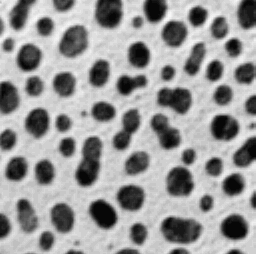

In [3]:
import net.imglib2.FinalInterval

image = ij.scifio().datasetIO().open("http://imagej.net/images/blobs.gif")

w = image.dimension(0); h = image.dimension(1)
slice = FinalInterval.createMinSize(0, 0, 0, w, h, 1)
input = ij.op().run("crop", image, slice, true)

ij.notebook().display(input)

Let's run a Gaussian on the image first so that we only get the major watersheds. Otherwise we will get a lot of smaller regions, instead of only the major ones that we want:

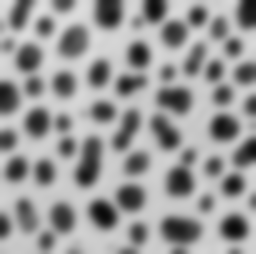

In [4]:
sigma = 4

blurredImg = ij.op().run("gauss", input, sigma)

ij.notebook().display(blurredImg)

Now that we have our input, we just have to define the other booleans before we call the `Op` and then we can run it and obtain the index `Img` that paints each `LabelRegion` in a different grayscale value.

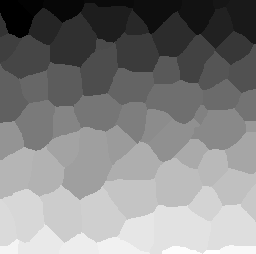

In [5]:
import net.imglib2.type.logic.BitType
useEightConnectivity = false

drawWatersheds = false

labeling = ij.op().image().watershed( blurredImg, useEightConnectivity, drawWatersheds)

//display the indexImg of the ImgLabeling
indexImg = labeling.getIndexImg()

ij.notebook().display(indexImg)

Now let's paint all of the watersheds onto a blank `Img` so that we can overlay them on the original. We can obtain all of the `LabelRegion`s in the `ImgLabeling` using the `LabelRegions` class, and we can create `Boundary` objects from each `LabelRegion` that will iterate over the edge pixels:

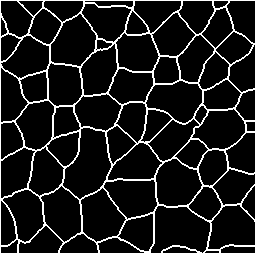

In [6]:
import net.imagej.ops.Ops
import net.imagej.ops.special.computer.Computers
import net.imglib2.roi.boundary.Boundary
import net.imglib2.roi.labeling.LabelRegions
import net.imglib2.type.numeric.integer.UnsignedByteType
import net.imglib2.IterableInterval

//create the edge image
edgesImg = ij.op().create().img(input, new UnsignedByteType())
edgesImgRA = edgesImg.randomAccess()
maxValue = edgesImg.firstElement().getMaxValue()

//get the regions from the ImgLabeling
regions = new LabelRegions(labeling)

//paint each edge region onto the edges image
for(region in regions){
    Boundary b = new Boundary(region)
    bcursor = b.cursor()
    while(bcursor.hasNext()){
        bcursor.fwd();
        edgesImgRA.setPosition(bcursor.getIntPosition(0), 0)
        edgesImgRA.setPosition(bcursor.getIntPosition(1), 1)
        edgesImgRA.get().setReal(maxValue)
    }
}

ij.notebook().display(edgesImg)

Now we can overlay our watershed bounds onto the original image:

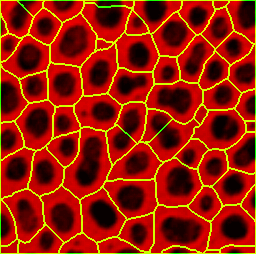

In [7]:
import net.imglib2.view.Views

//stack the centers on the input image
stack = Views.stack(input, edgesImg)

//TODO place in table next to original
ij.notebook().display(stack)
